In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import yfinance as yf
import datetime as dt

from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [63]:
crypto_currency = 'BTC-USD'

start = dt.datetime(2020,1,1)
end = dt.datetime.now()

In [64]:
data = yf.download(crypto_currency, start=start, end=end)
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095
...,...,...,...,...,...,...
2023-09-11,25831.714844,25883.947266,24930.296875,25162.654297,25162.654297,14600006467
2023-09-12,25160.658203,26451.939453,25133.078125,25833.343750,25833.343750,18657279324
2023-09-13,25837.554688,26376.113281,25781.123047,26228.324219,26228.324219,13072077070


In [65]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [66]:
prediction_days = 60
x_train, y_train = [], []
for x in range(prediction_days, len(scaler_data)):
    x_train.append(scaler_data[x-prediction_days:x, 0])
    y_train.append(scaler_data[x][0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Create Neural Network

In [67]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [68]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
41/41 [==============================] - 10s 89ms/step - loss: 0.0270
Epoch 2/25
41/41 [==============================] - 4s 88ms/step - loss: 0.0054
Epoch 3/25
41/41 [==============================] - 5s 119ms/step - loss: 0.0050
Epoch 4/25
41/41 [==============================] - 4s 91ms/step - loss: 0.0051
Epoch 5/25
41/41 [==============================] - 4s 90ms/step - loss: 0.0043
Epoch 6/25
41/41 [==============================] - 5s 118ms/step - loss: 0.0047
Epoch 7/25
41/41 [==============================] - 4s 88ms/step - loss: 0.0040
Epoch 8/25
41/41 [==============================] - 4s 88ms/step - loss: 0.0041
Epoch 9/25
41/41 [==============================] - 4s 105ms/step - loss: 0.0044
Epoch 10/25
41/41 [==============================] - 4s 102ms/step - loss: 0.0034
Epoch 11/25
41/41 [==============================] - 4s 90ms/step - loss: 0.0041
Epoch 12/25
41/41 [==============================] - 4s 91ms/step - loss: 0.0034
Epoch 13/25
41/41 [=============

# Testing the Model



In [69]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [70]:
test_start = dt.datetime(2022,1,1)
test_end =dt.datetime.now()
test_data = yf.download(crypto_currency, start=test_start, end=test_end)
actual_prices = test_data['Close'].values


[*********************100%%**********************]  1 of 1 completed


In [71]:
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)

In [72]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

20/20 [==============================] - 2s 24ms/step


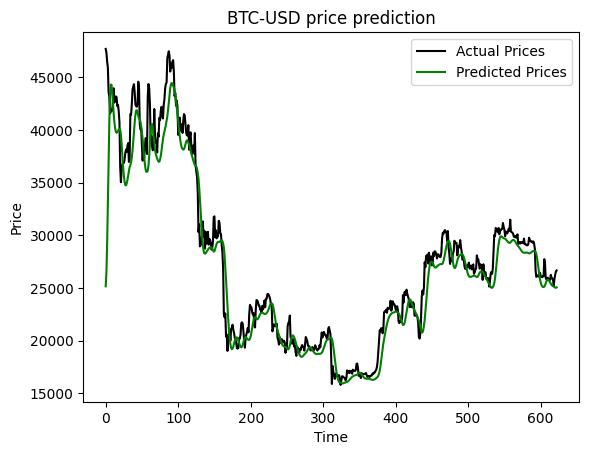

In [73]:
plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper right')
plt.show()

# Test Predict 60 days

In [74]:
prediction_result_days = 60

current_date = dt.datetime.now()
start_prediction_result_days = current_date - dt.timedelta(days=prediction_result_days)

end_prediction_result_days =dt.datetime.now()
data_prediction_result_days = yf.download(crypto_currency, start=start_prediction_result_days, end=end_prediction_result_days)
actual_price_of_prediction_result_days = data_prediction_result_days['Close'].values

# Initialize an array to store the predicted prices
predicted_prices = []

# Start with the most recent 60 days of data as input
initial_input = model_inputs[len(model_inputs) - 60 -1 - prediction_result_days:len(model_inputs)-60-1, 0]

[*********************100%%**********************]  1 of 1 completed


In [75]:
# Predict prices for 60 days
for i in range(prediction_result_days):
    # Reshape the input for the model
    input_data = np.reshape(initial_input, (1, prediction_result_days, 1))

    # Use the model to predict the next day's price
    next_day_prediction = model.predict(input_data)

    # Inverse transform the prediction to get the actual price
    next_day_price = scaler.inverse_transform(next_day_prediction)

    # Add the predicted price to the list
    predicted_prices.append(next_day_price[0, 0])

    # Update the input for the next iteration
    initial_input = np.roll(initial_input, shift=-1)
    initial_input[-1] = next_day_prediction[0, 0]

1/1 [==============================] - 0s 32ms/step


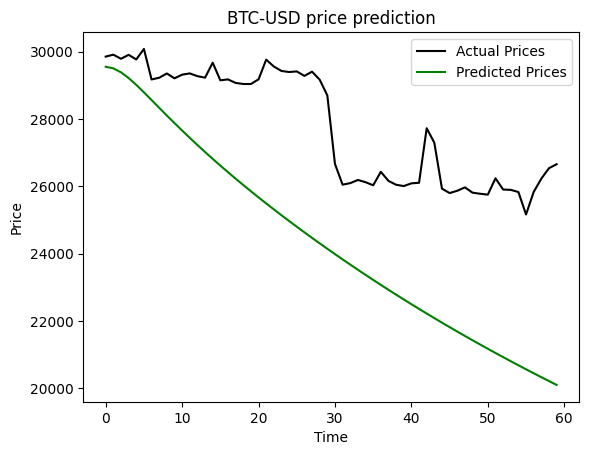

In [76]:
plt.plot(actual_price_of_prediction_result_days, color='black', label='Actual Prices')
plt.plot(predicted_prices, color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper right')
plt.show()